In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

In [2]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
target = 'duration'
def get_df(parquet_file_path):
    df = pd.read_parquet(parquet_file_path)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df["duration"].dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <=60)]
    df[categorical] = df[categorical].astype(str)
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']   # creating a new feature
    return df

In [3]:
import mlflow 
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-exp')

2025/08/30 06:17:16 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/30 06:17:16 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops/02-experiment-tracking/mlruns/1', creation_time=1756530340293, experiment_id='1', last_update_time=1756530340293, lifecycle_stage='active', name='nyc-taxi-exp', tags={}>

In [4]:
train_df = get_df("data/yellow_tripdata_2023-01.parquet")
val_df = get_df("data/yellow_tripdata_2023-02.parquet")

In [ ]:
dv = DictVectorizer()
new_feature = ['PU_DO']
train_dict = train_df[new_feature + numerical].to_dict(orient='records')
val_dict = val_df[new_feature + numerical].to_dict(orient='records')

x_train = dv.fit_transform(train_dict)
y_train = train_df[target].values

x_val = dv.transform(val_dict)
y_val = val_df[target].values

In [5]:
lr = LinearRegression()
lr.fit(x_train,y_train);

In [ ]:
with mlflow.start_run():
    alpha=0.01
    mlflow.set_tag('developer','vaibhav')
    mlflow.log_param('train_data_path','data/yellow_tripdata_2023-01.parquet')
    mlflow.log_param('val_data_path','data/yellow_tripdata_2023-02.parquet')
    mlflow.log_param('alpha',alpha)
    lr = Ridge()
    lr.fit(x_train,y_train)
    y_pred = lr.predict(x_val)
    rmse = mean_squared_error(y_pred,y_val,squared=False)
    mlflow.log_param('rmse',rmse)

In [12]:
y_pred = lr.predict(x_val)

In [13]:
mse = mean_squared_error(y_pred,y_val,squared=False)
mse

5.244604500966886

/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


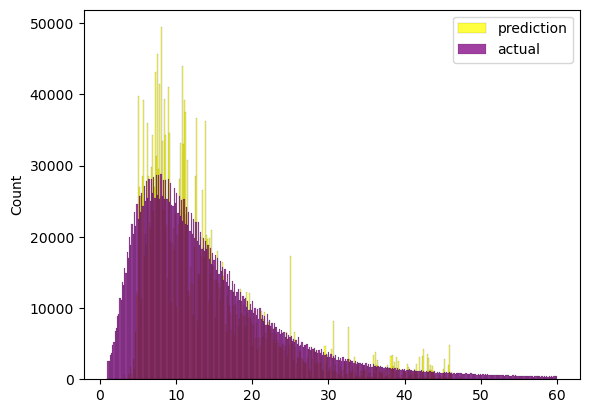

In [8]:
sns.histplot(y_pred,label='prediction',color='yellow')
sns.histplot(y_val,label='actual',color='purple')
plt.legend()

In [9]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)